In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter('ignore')

syntax = pd.read_csv('syntax for model.csv')
entity = pd.read_csv('entity for model.csv')
scrape = pd.read_csv('mkt funnel keywords for model.csv')

In [2]:
# features created from syntax - part of speech
syntax.sample()

,query,adj adv
887,how to build a team culture,8.24


In [3]:
# features created from entities and their types
# how many entities of certain types have showed up for each query's search result
entity.sample()

,query,price_phone,organization,work of art,salience std
955,how to get rid of halitosis home remedies,0.0,12.9,6.45,0.29


In [4]:
# Count of search result types for each query
scrape.sample()

,query,INT,Answer Box,Image,Local Pack,News,Organic,Organic & Sitelinks,Paid Search Ad,People Also Ask,Shopping Ad,Video,len
1530,ups car insurance discount,transactional,0.0,0.0,0.0,0.0,9.0,0.0,2.0,4.0,0.0,0.0,4


In [5]:
df = scrape.merge(syntax, on='query')
df = df.merge(entity, on='query')

# Delete the least important or least frequent search result types - explored from the model without nlp features
df = df.drop(['Local Pack', 'Image', 'Organic & Sitelinks', 'Video', 'News', 'Shopping Ad'], axis=1)

df.sample()

,query,INT,Answer Box,Organic,Paid Search Ad,People Also Ask,len,adj adv,price_phone,organization,work of art,salience std
212,best dental care products,informational,1.0,8.0,0.0,4.0,4,15.38,0.0,14.29,0.0,0.33


## Classification Model with Random Forest

### y - funnel types: informational, navigational, transactional
### https://blog.alexa.com/how-to-optimize-for-three-types-of-buyer-keywords/

In [6]:
X = df.drop(['query', 'INT'], axis=1)
y = df[['INT']]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=234)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1274, 10) (1274, 1)
(546, 10) (546, 1)


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
# random forest model creation
rfc = RandomForestClassifier(n_estimators=1000, max_features="sqrt", min_samples_split=2,
                             oob_score=True, random_state=100)
rfc.fit(X_train,y_train)
# predictions
rfc_predict = rfc.predict(X_test)

In [8]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
pred = rfc.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[143  29  15]
 [ 25 138  31]
 [ 15  32 118]]
               precision    recall  f1-score   support

informational       0.78      0.76      0.77       187
 navigational       0.69      0.71      0.70       194
transactional       0.72      0.72      0.72       165

     accuracy                           0.73       546
    macro avg       0.73      0.73      0.73       546
 weighted avg       0.73      0.73      0.73       546



In [9]:
from matplotlib import pyplot as plt

importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [10]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, rfc.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances = importances.sort_values(by='Gini-importance', ascending=False)

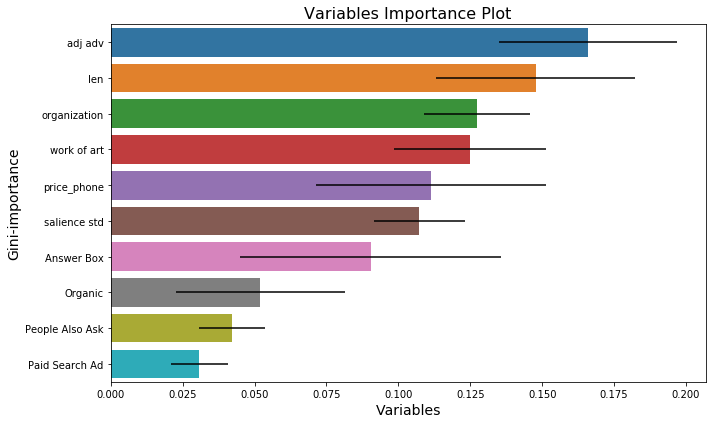

In [11]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))

fig = sns.barplot(y=importances.index, x='Gini-importance', data=importances, ax=ax, xerr=std[indices])
ax.set_xlabel('Variables', fontsize=14)
ax.set_ylabel('Gini-importance', fontsize=14)
ax.set_title('Variables Importance Plot', fontsize=16)
plt.tight_layout()
plt.show()